# Introdução a Séries Temporais

Tutorial for improve skills: 'Séries Temporais com python/pandas/statsmodels - Parte 08' (ORMaster) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Séries Temporais com python/pandas/statsmodels - Parte 01 [ORMaster.](https://www.youtube.com/playlist?list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-)** 

**ronaldolagepessoa: [GitHub.](https://github.com/ronaldolagepessoa/timeseries)**

## Load packages

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

In [3]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 16 # Number of CPU limit
TARGET_NAME = 'CHURN'

## Aplicando modelos com variáveis exógenas (Variáveis Externas)

Os modelos apresentados até agora possuem característica endógena, i.e., apenas consideram como _input_ as informações contidas na própria séries temporal.

Em boa parte das situações reais, entretanto, é necessário considerar efeitos externos às séries temporais para melhorar o desempenho de modelos preditivos. Esses efeitos externos são chamados de variáveis exógenas.

Para exemplificar o uso de variáveis exógenas, utilizaremos as informações contidas no arquivo ```clima_india.csv```.

In [5]:
Path = ""

data = pd.read_csv(Path+"data/clima_india.csv", parse_dates=True, index_col='date')
print(data.shape)
data.head()

(1462, 4)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
train = data.copy()
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Utilizaremos a série de temperaturas médias contidas na coluna ```meantemp```.

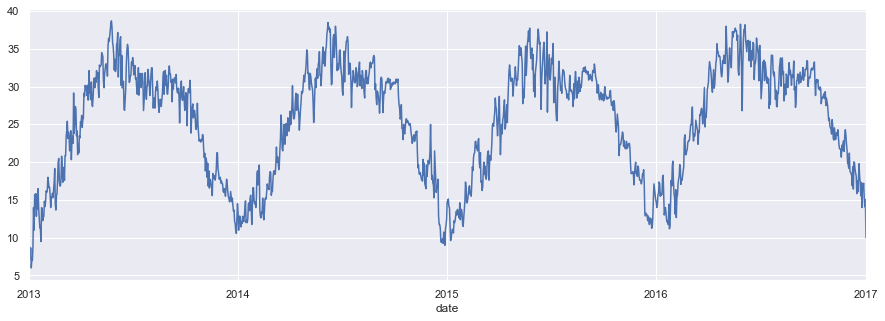

In [9]:
train.meantemp.plot(figsize=(15, 5));

Para aplicar um modelo preditivos com variáveis exógenas, precisamos definir primeiro as variáveis endógenas. Para uma séries temporal, as variáveis endógenas são os valores anteriores ao período alvo. Definimos o número de variáveis endógenas como o número de _lags_ $p$. Para o exemplo, faremos $p=5$.

Criaremos uma cópia do ```DataFrame``` ```df``` contendo somente a coluna ```meantemp```, chamando de ```df1```. Em seguida, utilizaremos um _loop_ para criar uma coluna para cada variável endógena utilizando o comando ```Series.shift()```. Para finalizar, eliminaremos as linhas contendo valores vazios com o comando ```DataFrame.dropna()```.

In [11]:
p = 5

df1 = train[['meantemp']].copy()

for i in range(p):
    df1[f'x_{i+1}'] = df1.meantemp.shift(i + 1)

df1.dropna(axis=0, inplace=True)

df1.head()

,meantemp,x_1,x_2,x_3,x_4,x_5
date,,,,,,
2013-01-06,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-07,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
2013-01-08,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
2013-01-09,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
2013-01-10,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000


Com a estrutura criada acima, podemos aplicar qualquer modelo de regressão disponível na literatura. Para o exemplo, aplicaremos um modelo regressivo baseado em árvore de decisão. Um modelo de regressão recebe uma matriz de valores das variáveis de entrada $X$ e um vetor de valores da variável de saída $y$. Utilizaremos o comando ```DataFrame.drop()``` para selecionar somente as variávels $X$ e o comando ```DataFrame.nome_da_coluna``` para selecionar a variável $y$.

In [12]:
X = df1.drop('meantemp', axis=1)
y = df1.meantemp

Para aplicar o modelo de regressão baseado em árvore de decisão, utilizaremos o pacote de _machine learning_ ```sklearn```. Para tanto, faremos a importação da classe ```DecisionTreeRegressor``` presente no subpacote ```sklearn.tree```.

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_r = DecisionTreeRegressor()
tree_r.fit(X, y)

DecisionTreeRegressor()

Faremos a plotagem dos dados reais e previstos para avaliar o ajuste do modelo aos dados.

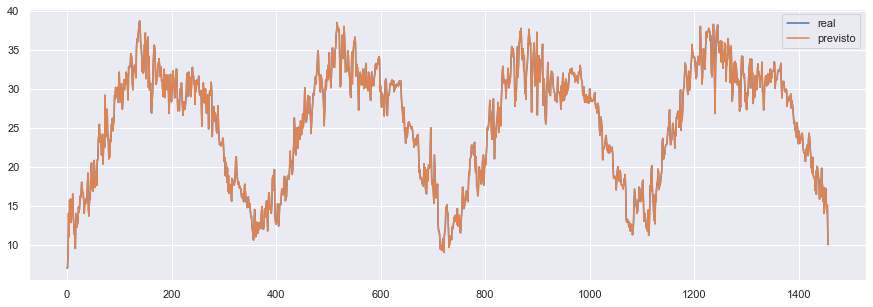

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df1.meantemp.values)
plt.plot(tree_r.predict(X))
plt.legend(['real', 'previsto'])

Analisando o gráfico gerado, percebemos que o modelo se ajustou com "perfeição" nos dados de entrada, ao ponto de não ser possível enxergar a linha azul (valores reais). 

Isso é bom ou ruim?

Modelos de regressão baseados em árvore de decisão possuem alto risco de _overfitting_. O gráfico acima mostra um exemplo claro de _overffiting_, onde o modelo tem a "presunsão" de achar que identificou perfeitamente o padrão de comportamento da série (o que é impossível).

Para aumentar a generalização do modelo, limitaremos a profundidade da árvore de decisão passando um valor específico para o parâmetro ```max_depth```.

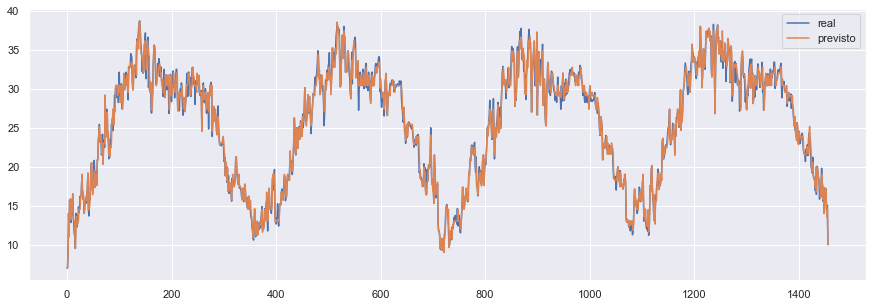

In [16]:
tree_r = DecisionTreeRegressor(max_depth=10)
tree_r.fit(X, y)

plt.figure(figsize=(15, 5))
plt.plot(df1.meantemp.values)
plt.plot(tree_r.predict(X))
plt.legend(['real', 'previsto'])

Para acrescentar variáveis exógenas, baste acrescentarmos no ```DataFrame``` ```df1``` colunas com os valores associados as mesmas. Para o exemplo, utilizaremos o mês como variável externa.

In [31]:
df1['month'] = df1.index.month
df1.head()

,meantemp,x_1,x_2,x_3,x_4,x_5,month
date,,,,,,,
2013-01-06,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,1
2013-01-07,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,1
2013-01-08,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,1
2013-01-09,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,1
2013-01-10,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,1


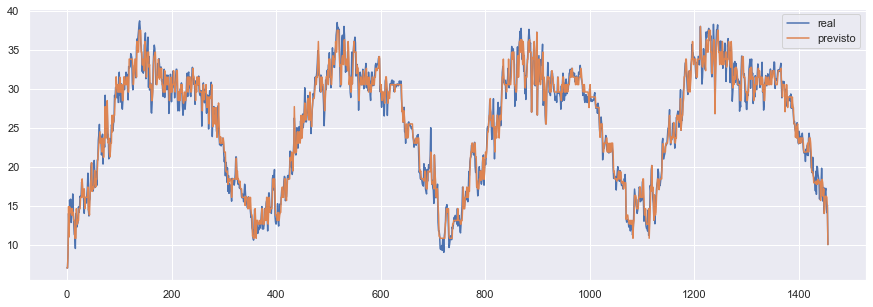

In [32]:
X = df1.drop('meantemp', axis=1)
y = df1.meantemp

tree_r = DecisionTreeRegressor(max_depth=7)
tree_r.fit(X, y)

plt.figure(figsize=(15, 5))
plt.plot(df1.meantemp.values)
plt.plot(tree_r.predict(X))
plt.legend(['real', 'previsto']);

Para avaliar o modelo, utilizaremos a validação _train/test_, calculando o erro médio quadrático das previsões feitas no conjunto de testes.

In [123]:
train_size = int(len(X) * 2/3)

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

tree_r = DecisionTreeRegressor(max_depth=4)
tree_r.fit(X_train, y_train)

((y_test - tree_r.predict(X_test)) ** 2).mean()

2.657702190345183

In [24]:
y

date
2013-01-06     7.000000
2013-01-07     7.000000
2013-01-08     8.857143
2013-01-09    14.000000
2013-01-10    11.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1457, dtype: float64

In [29]:
TEST_SIZE = 1 - 2/3

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y, 
#                                                       stratify = y,
                                                      test_size=TEST_SIZE, 
                                                      random_state=SEED) 

print(f"Train 70%, Valid 30% data: {X_train.shape, X_valid.shape}",\
                                    y_train.shape, y_valid.shape)

tree_r = DecisionTreeRegressor(max_depth=4)
tree_r.fit(X_train, y_train)

((y_valid - tree_r.predict(X_valid)) ** 2).mean()

Train 70%, Valid 30% data: ((971, 5), (486, 5)) (971,) (486,)


3.001143751961859

O número de _lags_ e a profundidade da árvore podem estar relacionadas. No código abaixo temos o procedimento de testes para os dois parâmetros.

In [83]:
%%time

p_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
# p = 3
# max_depth = 5
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 50, 100, 150, 200]
TEST_SIZE = 1 - 2/3

p_r = []
depth_r = []
mse_r = []

df1 = train[['meantemp']].copy()

for max_depth in max_depth_list: 
    for p in p_list:
        for i in range(p):
            df1[f'x_{i+1}'] = df1.meantemp.shift(i + 1)

        df1.dropna(axis=0, inplace=True)
        df1['month'] = df1.index.month

        X = df1.drop('meantemp', axis=1)
        y = df1.meantemp

        X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                              y, 
        #                                                       stratify = y,
                                                              test_size=TEST_SIZE, 
                                                              random_state=SEED) 

    #     print(f"Train 70%, Valid 30% data: {X_train.shape, X_valid.shape}",\
    #                                         y_train.shape, y_valid.shape)

        tree_r = DecisionTreeRegressor(max_depth=max_depth, random_state=SEED)
        tree_r.fit(X_train, y_train)
        
        mse = ((y_valid - tree_r.predict(X_valid)) ** 2).mean()
        
        p_r.append(p)
        depth_r.append(max_depth)
        mse_r.append(mse)        

        print(f"P value: {p} | Max Depth: {max_depth} | MSE: {mse}")        
        
    print(f"====================================================")

P value: 1 | Max Depth: 2 | MSE: 6.840587134449699
P value: 2 | Max Depth: 2 | MSE: 7.089367095860292
P value: 3 | Max Depth: 2 | MSE: 6.481993846907413
P value: 4 | Max Depth: 2 | MSE: 6.686507743400926
P value: 5 | Max Depth: 2 | MSE: 6.395313567599201
P value: 6 | Max Depth: 2 | MSE: 6.678642941937202
P value: 7 | Max Depth: 2 | MSE: 6.212770547998975
P value: 8 | Max Depth: 2 | MSE: 6.847910617327918
P value: 9 | Max Depth: 2 | MSE: 5.767379087671764
P value: 10 | Max Depth: 2 | MSE: 5.779347416503144
P value: 15 | Max Depth: 2 | MSE: 6.076538160521916
P value: 1 | Max Depth: 3 | MSE: 3.8012097079486953
P value: 2 | Max Depth: 3 | MSE: 3.325992268534932
P value: 3 | Max Depth: 3 | MSE: 4.217486639199091
P value: 4 | Max Depth: 3 | MSE: 3.5203240047766604
P value: 5 | Max Depth: 3 | MSE: 3.5721936679408977
P value: 6 | Max Depth: 3 | MSE: 3.6849819246431537
P value: 7 | Max Depth: 3 | MSE: 3.429625972269125
P value: 8 | Max Depth: 3 | MSE: 3.5506405486982753
P value: 9 | Max Depth: 

P value: 7 | Max Depth: 150 | MSE: 4.259099795892441
P value: 8 | Max Depth: 150 | MSE: 4.861975955312589
P value: 9 | Max Depth: 150 | MSE: 4.700120179427007
P value: 10 | Max Depth: 150 | MSE: 3.9853387711982475
P value: 15 | Max Depth: 150 | MSE: 4.420975156406461
P value: 1 | Max Depth: 200 | MSE: 4.54903622073898
P value: 2 | Max Depth: 200 | MSE: 4.761323071653828
P value: 3 | Max Depth: 200 | MSE: 4.656732717858775
P value: 4 | Max Depth: 200 | MSE: 4.570550595317504
P value: 5 | Max Depth: 200 | MSE: 4.623074418229852
P value: 6 | Max Depth: 200 | MSE: 3.9033370522427884
P value: 7 | Max Depth: 200 | MSE: 4.360514520778122
P value: 8 | Max Depth: 200 | MSE: 4.586849142366068
P value: 9 | Max Depth: 200 | MSE: 5.030071228757013
P value: 10 | Max Depth: 200 | MSE: 4.377968671133181
P value: 15 | Max Depth: 200 | MSE: 4.5774359861060665
Wall time: 1.51 s


## Analise results

In [84]:
results = {'p': p_r,
          'Max Depth': depth_r,
          'MSE': mse_r}


df_results = pd.DataFrame(results)
print(df_results.shape)
df_results.head()

(165, 3)


,p,Max Depth,MSE
0,1,2,6.840587
1,2,2,7.089367
2,3,2,6.481994
3,4,2,6.686508
4,5,2,6.395314


In [85]:
df_results[df_results["MSE"] == df_results["MSE"].min() ]

,p,Max Depth,MSE
28,7,4,2.852162


In [70]:
df_results["MSE"].min()

2.8521621724318003

In [86]:
df_results.loc[df_results["MSE"] == df_results["MSE"].min(), "Max Depth"]

28    4
Name: Max Depth, dtype: int64

In [1]:
p = int(df_results.loc[df_results["MSE"] == df_results["MSE"].min(), "p"])
max_depth = int(df_results.loc[df_results["MSE"] == df_results["MSE"].min(), "Max Depth"])
TEST_SIZE = 1 - 2/3

df1 = train[['meantemp']].copy()

for i in range(p):
    df1[f'x_{i+1}'] = df1.meantemp.shift(i + 1)

df1.dropna(axis=0, inplace=True)
df1['month'] = df1.index.month

X = df1.drop('meantemp', axis=1)
y = df1.meantemp

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y, 
#                                                       stratify = y,
                                                      test_size=TEST_SIZE, 
                                                      random_state=SEED) 

# print(f"Train 70%, Valid 30% data: {X_train.shape, X_valid.shape}",\
#                                     y_train.shape, y_valid.shape)

tree_r = DecisionTreeRegressor(max_depth=max_depth, random_state=SEED)
tree_r.fit(X_train, y_train)

MSE = ((y_valid - tree_r.predict(X_valid)) ** 2).mean()

print(f"P value: {p} | Max Deep: {max_depth} | MSE: {MSE}")

NameError: name 'df_results' is not defined

Para fazer a previsão do próximo período, precisamos das temperaturas dos três últimos dias (já que escolhemos $p=3$) e o número do mês para esse mesmo período. Para tanto, utilizaremos o comando ```DataFrame.tail()```.

In [82]:
df1.tail()

,meantemp,x_1,x_2,x_3,x_4,x_5,x_6,x_7,month
date,,,,,,,,,
2016-12-28,17.217391,16.850000,17.142857,14.000000,17.318182,15.550000,17.285714,18.050000,12
2016-12-29,15.238095,17.217391,16.850000,17.142857,14.000000,17.318182,15.550000,17.285714,12
2016-12-30,14.095238,15.238095,17.217391,16.850000,17.142857,14.000000,17.318182,15.550000,12
2016-12-31,15.052632,14.095238,15.238095,17.217391,16.850000,17.142857,14.000000,17.318182,12
2017-01-01,10.000000,15.052632,14.095238,15.238095,17.217391,16.850000,17.142857,14.000000,1


Criaremos uma variável chamada ```X_new``` para guardar os valores de entrada. Esse procedimento poder ser feita de maneira manual, como mostrado abaixo.

In [89]:
X_test = [[10, 15.052632, 14.095238, 1]]
X_test

[[10, 15.052632, 14.095238, 1]]

Ou de maneira automática com o código abaixo.

In [91]:
next_pred = df1.index[-1] + np.timedelta64(1, 'D')
X_test = [list(np.flip(df1.meantemp.tail(p).values, axis=0)) + [next_pred.month]]
X_test

[[10.0,
  15.052631578947368,
  14.095238095238097,
  15.238095238095235,
  17.217391304347824,
  16.85,
  17.142857142857142,
  1]]

In [93]:
tree_r.predict(X_test)

array([10.81297619])

A previsão da temperatura média para o período ```2017-01-02``` é de $11.37073171$.